In [13]:
import numpy as np
import matplotlib.pyplot as plt
from fipy import CellVariable, Grid1D, TransientTerm, DiffusionTerm, DefaultSolver
import time

In [14]:
def solution(x, t, m, C):
    """
    Analytical Barenblatt–Pattle solution for the porous-medium equation.
    ∂u/∂t = ∇·(m u^(m-1) ∇u)
    """
    alpha = 1.0 / (m + 1)
    factor = t**(-alpha)
    inner = C - (m - 1) / (2 * m * (m + 1)) * x**2 / (t**(2 * alpha))
    return factor * np.maximum(inner, 0)**(1.0 / (m - 1))

In [15]:
def run_fipy(nx, L=15., T=1., m=3, C=1, t0=0.001):
    """
    Solve the porous-media equation on a 1D grid with nx cells.
    Returns the grid spacing h and the L2 error norm at final time.
    """
    # Spatial discretization
    dx = 2 * L / nx
    mesh = Grid1D(nx=nx, dx=dx) - [[L]]  # Domain [-L, L]
    x = mesh.cellCenters[0]

    # Initial condition from analytical solution at t0
    phi = CellVariable(name="solution variable", mesh=mesh,
                       value=solution(np.array(x), t0, m, C))
    phi.constrain(0, where=mesh.facesLeft)
    phi.constrain(0, where=mesh.facesRight)

    # Define the PDE: ∂φ/∂t = ∇·(m φ^(m-1) ∇φ)
    eq = TransientTerm() == DiffusionTerm(coeff=m * phi**(m-1))

    # Choose time-step small enough: dt proportional to dx^2 to minimize temporal error
    dt = 0.01 * dx**2
    nt = int(np.ceil(T / dt))

    # Time-stepping
    solver = DefaultSolver()
    for _ in range(nt):
        eq.solve(var=phi, dt=dt, solver=solver)

    # Extract numeric solution as a NumPy array
    u_num = np.array(phi.value)
    # Compute exact solution at final time
    u_ex = solution(np.array(x), t0 + T, m, C)

    # Compute L2 error: sqrt( sum((u_num - u_ex)^2 * dx) )
    L2 = np.sqrt(np.sum((u_num - u_ex)**2) * dx)
    return dx, L2

nx= 100, h=0.30000, L2 error=8.38066e-02, time=7.67684 s
nx= 112, h=0.26786, L2 error=9.91484e-02, time=9.06819 s
nx= 126, h=0.23810, L2 error=5.02687e-02, time=11.54030 s
nx= 141, h=0.21277, L2 error=1.18017e-01, time=14.43083 s
nx= 158, h=0.18987, L2 error=4.28879e-02, time=18.07652 s
nx= 178, h=0.16854, L2 error=5.59086e-02, time=22.66354 s
nx= 199, h=0.15075, L2 error=6.00522e-02, time=28.61032 s
nx= 224, h=0.13393, L2 error=1.54908e-02, time=36.30152 s
nx= 251, h=0.11952, L2 error=5.96551e-02, time=46.11375 s
nx= 281, h=0.10676, L2 error=2.05613e-02, time=57.55934 s
nx= 316, h=0.09494, L2 error=4.97809e-02, time=73.75132 s
nx= 354, h=0.08475, L2 error=1.43043e-02, time=93.60043 s
nx= 397, h=0.07557, L2 error=2.83885e-02, time=117.19791 s
nx= 446, h=0.06726, L2 error=1.80208e-02, time=149.51579 s
nx= 500, h=0.06000, L2 error=7.90457e-03, time=188.90131 s

Observed order of convergence p = 1.23



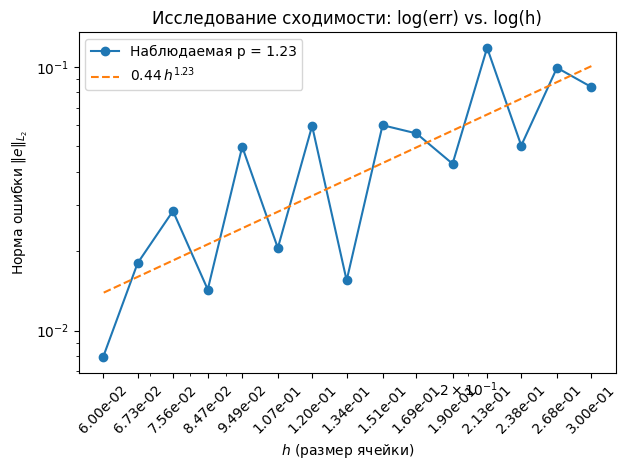

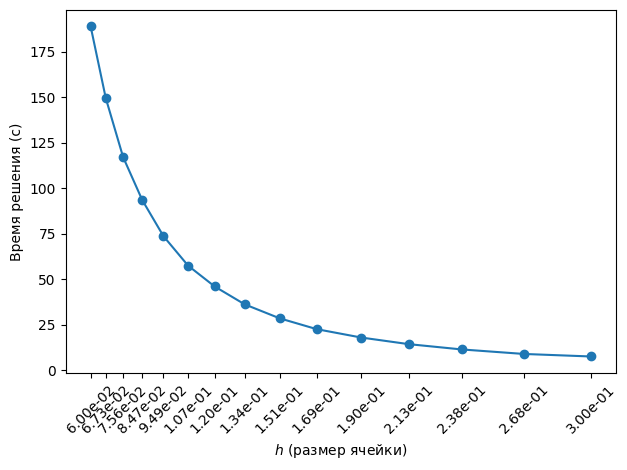

In [16]:
if __name__ == "__main__":
    # Grid-refinement study with many h steps
    nx_min, nx_max, num_steps = 100, 500, 15
    raw = np.logspace(np.log10(nx_min), np.log10(nx_max), num=num_steps)
    nx_list = np.unique(np.round(raw).astype(int))

    hs, errs, times = [], [], []
    for nx in nx_list:
        start = time.perf_counter()
        h, e = run_fipy(nx)
        dt = time.perf_counter() - start
        hs.append(h)
        errs.append(e)
        times.append(dt)
        print(f"nx={nx:4d}, h={h:.5f}, L2 error={e:.5e}, time={dt:.5f} s")

    hs = np.array(hs)
    errs = np.array(errs)
    times = np.array(times)

    # Fit log(err) = p * log(h) + log(C)
    coeffs = np.polyfit(np.log(hs), np.log(errs), 1)
    p_fit, C_fit = coeffs[0], np.exp(coeffs[1])

    print(f"\nObserved order of convergence p = {p_fit:.2f}\n")

    # Plot convergence on a log-log scale
    plt.figure()
    plt.loglog(hs, errs, 'o-', label=fr"Наблюдаемая p = {p_fit:.2f}")
    plt.loglog(hs, C_fit * hs**p_fit, '--',
           label=rf"${C_fit:.2g}\,h^{{{p_fit:.2f}}}$")    
    plt.xlabel(r"$h$ (размер ячейки)")
    plt.ylabel(r"Норма ошибки $\|e\|_{L_2}$")
    plt.xticks(hs, [f"{h:.2e}" for h in hs], rotation=45)
    plt.legend()
    plt.title("Исследование сходимости: log(err) vs. log(h)")
    plt.tight_layout()
    plt.show()

    # Plot solve time on a log-log scale
    plt.figure()
    plt.plot(hs, times, 'o-')
    plt.xlabel(r"$h$ (размер ячейки)")
    plt.ylabel("Время решения (с)")
    plt.xticks(hs, [f"{h:.2e}" for h in hs], rotation=45)
    plt.tight_layout()
    plt.show()